# Localization

Predict a single bounding box per image. Uses the MobileNet-based classifier as the starting point.

**NOTE:** The results in this notebook are similar to those shown in the book but are not 100% the same. Because neural networks are initialized with random numbers, each training session will give slightly different results.

## Load the annotations

In [1]:
import sys
print(sys.version)

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


In [2]:
import os, sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
data_dir = "snacks"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

In [4]:
train_annotations = pd.read_csv(os.path.join(data_dir, "annotations-train.csv"))
train_annotations.head()

,image_id,x_min,x_max,y_min,y_max,class_name,folder
0,009218ad38ab2010,0.192620,0.729831,0.127606,0.662219,cake,cake
1,009218ad38ab2010,0.802377,1.000000,0.102585,0.405338,ice cream,cake
2,009218ad38ab2010,0.814884,0.970607,0.121768,0.357798,ice cream,cake
3,00c7515143b32051,0.135084,0.904315,0.081735,0.909091,cake,muffin
4,00c7515143b32051,0.155722,0.910569,0.083403,0.893244,muffin,muffin


In [5]:
len(train_annotations)

7040

In [6]:
val_annotations = pd.read_csv(os.path.join(data_dir, "annotations-val.csv"))
test_annotations = pd.read_csv(os.path.join(data_dir, "annotations-test.csv"))

In [7]:
len(val_annotations), len(test_annotations)

(1417, 1380)

## Plot training image + its bounding boxes

In [8]:
image_width = 224
image_height = 224

In [9]:
from helpers import plot_image

/home/zhangfx/anaconda3/envs/ml-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zhangfx/anaconda3/envs/ml-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zhangfx/anaconda3/envs/ml-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zhangfx/anaconda3/envs/ml-env/lib/pyt

In [10]:
from keras.preprocessing import image

def plot_image_from_row(row, image_dir):
    image_path = os.path.join(image_dir, row["folder"], row["image_id"] + ".jpg")
    img = image.load_img(image_path, target_size=(image_width, image_height))
    bbox = (row["x_min"], row["x_max"], row["y_min"], row["y_max"], row["class_name"])
    plot_image(img, [bbox])

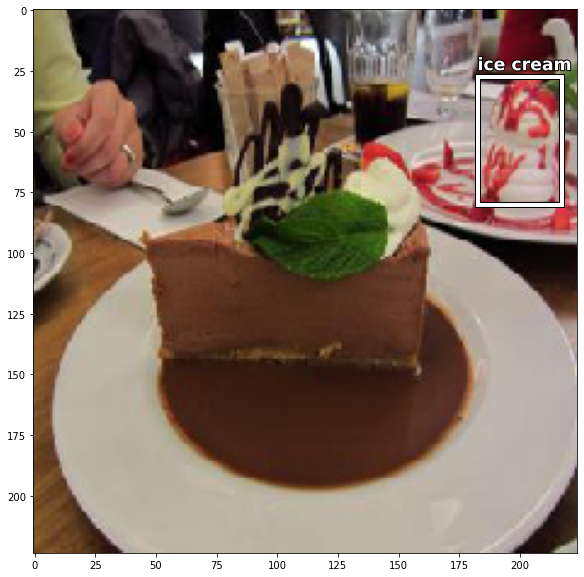

In [14]:
plot_image_from_row(train_annotations.iloc[2], train_dir)

## Custom generator

In [15]:
from helpers import BoundingBoxGenerator

In [16]:
batch_size = 32
train_generator = BoundingBoxGenerator(train_annotations, train_dir, 
                                       image_height, image_width, 
                                       batch_size, shuffle=True)

In [17]:
train_iter = iter(train_generator)
X, (y_class, y_bbox) = next(train_iter)

In [18]:
X.shape, y_class.shape, y_bbox.shape

((32, 224, 224, 3), (32,), (32, 4))

In [19]:
y_bbox

array([[0.      , 0.942464, 0.062382, 1.      ],
       [0.524667, 0.82    , 0.183419, 0.86427 ],
       [0.294599, 0.833061, 0.662848, 0.97545 ],
       [0.038569, 0.962986, 0.037817, 0.962393],
       [0.430023, 1.      , 0.      , 1.      ],
       [0.073842, 0.874844, 0.115192, 0.959933],
       [0.185728, 0.721408, 0.241199, 0.877445],
       [0.350548, 0.599374, 0.726135, 0.957747],
       [0.2075  , 0.825   , 0.173   , 0.646333],
       [0.368981, 0.667917, 0.126772, 0.973311],
       [0.446009, 0.749609, 0.234742, 0.671362],
       [0.78    , 0.906667, 0.686667, 0.858333],
       [0.108184, 0.444026, 0.610381, 0.942464],
       [0.343965, 0.893684, 0.336773, 0.954034],
       [0.577629, 0.716194, 0.497312, 1.      ],
       [0.644041, 0.781168, 0.35916 , 0.761706],
       [0.604128, 1.      , 0.147623, 0.788991],
       [0.224829, 0.678397, 0.171554, 0.86217 ],
       [0.06005 , 0.982485, 0.257661, 0.941213],
       [0.011457, 1.      , 0.04419 , 0.815057],
       [0.102564, 0.

In [20]:
y_class

array([ 8,  7,  6,  0,  9, 15, 11,  6,  2,  8, 10,  6,  4, 18, 13,  7,  8,
       19,  2,  5, 10,  5, 18, 18,  5,  3,  6,  6,  9,  7, 17,  7])

In [21]:
from helpers import labels
list(map(lambda x: labels[x], y_class))

['hot dog',
 'grape',
 'doughnut',
 'apple',
 'ice cream',
 'pretzel',
 'muffin',
 'doughnut',
 'cake',
 'hot dog',
 'juice',
 'doughnut',
 'carrot',
 'waffle',
 'pineapple',
 'grape',
 'hot dog',
 'watermelon',
 'cake',
 'cookie',
 'juice',
 'cookie',
 'waffle',
 'waffle',
 'cookie',
 'candy',
 'doughnut',
 'doughnut',
 'ice cream',
 'grape',
 'strawberry',
 'grape']

In [22]:
len(train_generator)

220

In [23]:
def plot_image_from_batch(X, y_class, y_bbox, img_idx):
    class_name = labels[y_class[img_idx]]
    bbox = y_bbox[img_idx]
    plot_image(X[img_idx], [[*bbox, class_name]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


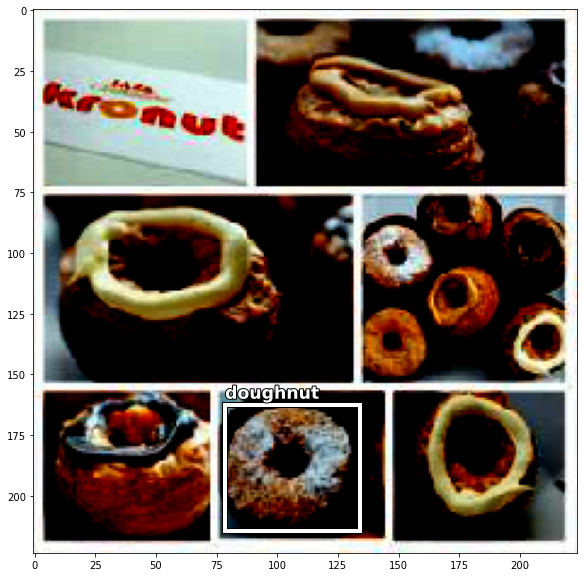

In [24]:
plot_image_from_batch(X, y_class, y_bbox, 7)

In [25]:
X, (y_class, y_bbox) = next(train_iter)

## Load the best model from last time

In [26]:
import keras
from keras.models import Sequential
from keras.layers import *
from keras.models import Model, load_model
from keras import optimizers, callbacks
import keras.backend as K
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
 
KTF.set_session(tf.Session(config=tf.ConfigProto(device_count={'gpu':0})))

classifier_model = load_model("checkpoints/multisnacks-0.7162-0.8419.hdf5")







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
classifier_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                20500     
_________________________________________________________________
activation_3 (Activation)    (None, 20)                0         
Total params: 3,249,364
Trainable params: 3,227,476
Non-trainable params: 21,888
_________________________________________________________________


## Add the bounding box predictor to the model

In [28]:
num_classes = 20

# The MobileNet feature extractor is the first "layer".
base_model = classifier_model.layers[0]

# Add a global average pooling layer after MobileNet.
pool = GlobalAveragePooling2D()(base_model.outputs[0])

# Reconstruct the classifier layers.
clf = Dropout(0.7)(pool)
clf = Dense(num_classes, kernel_regularizer=keras.regularizers.l2(0.01), name="dense_class")(clf)
clf = Activation("softmax", name="class_prediction")(clf)

# Add new layers for the bounding box predictor.
bbox = Conv2D(512, 3, padding="same")(base_model.outputs[0])
bbox = BatchNormalization()(bbox)
bbox = Activation("relu")(bbox)
bbox = GlobalAveragePooling2D()(bbox)
bbox = Dense(4, name="bbox_prediction")(bbox)

# Create the new model.
model = Model(inputs=base_model.inputs, outputs=[clf, bbox])

In [29]:
for layer in base_model.layers:
    layer.trainable = False

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

Put the old weights back, or the classifier won't work anymore:

In [31]:
layer_dict = {layer.name:i for i, layer in enumerate(model.layers)}

# Get the weights from the checkpoint model.
weights, biases = classifier_model.layers[-2].get_weights()

# Put them into the new model.
model.layers[layer_dict["dense_class"]].set_weights([weights, biases])

In [32]:
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[1.0, 10.0],
              optimizer=optimizers.Adam(lr=1e-3),
              metrics={ "class_prediction": "accuracy" })

## Try the model on an image

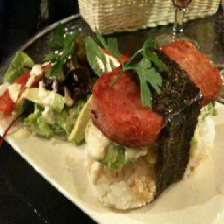

In [33]:
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image

img = image.load_img(train_dir + "/salad/2ad03070c5900aac.jpg", target_size=(image_width, image_height))
img

In [34]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [35]:
preds = model.predict(x)
preds

[array([[5.5659082e-05, 7.1897813e-07, 7.4317250e-05, 4.5375164e-06,
         2.9821682e-04, 2.9114778e-06, 5.2616288e-06, 4.8986397e-04,
         6.5828249e-04, 6.8758155e-04, 3.6887937e-05, 6.2949434e-06,
         1.6075590e-05, 2.1348683e-04, 1.9503818e-06, 8.5053324e-07,
         9.7398055e-01, 2.2265238e-03, 1.5832029e-03, 1.9656979e-02]],
       dtype=float32),
 array([[ 0.8035048,  3.0957701,  1.2277336, -0.9234106]], dtype=float32)]

In [36]:
len(preds)

2

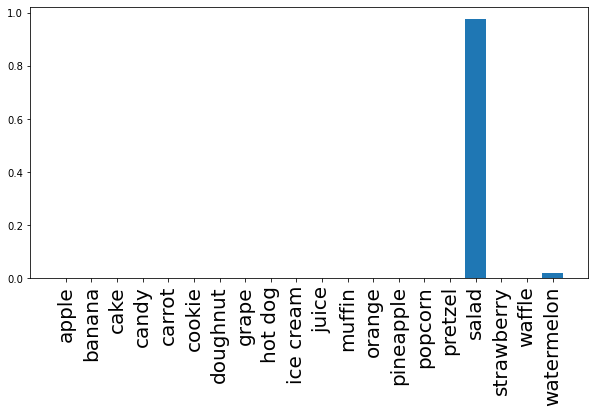

In [37]:
plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), preds[0].squeeze())
plt.xticks(range(num_classes), labels, rotation=90, fontsize=20)
plt.show()

In [38]:
preds = classifier_model.predict(x)
preds

array([[5.5659082e-05, 7.1897813e-07, 7.4317250e-05, 4.5375164e-06,
        2.9821682e-04, 2.9114778e-06, 5.2616288e-06, 4.8986397e-04,
        6.5828249e-04, 6.8758155e-04, 3.6887937e-05, 6.2949434e-06,
        1.6075590e-05, 2.1348683e-04, 1.9503818e-06, 8.5053324e-07,
        9.7398055e-01, 2.2265238e-03, 1.5832029e-03, 1.9656979e-02]],
      dtype=float32)

In [39]:
preds = model.predict_generator(train_generator)

In [40]:
preds[1].shape

(7040, 4)

## Train the model

In [41]:
val_generator = BoundingBoxGenerator(val_annotations, val_dir, 
                                     image_height, image_width, 
                                     batch_size, shuffle=False)

In [42]:
from helpers import combine_histories, plot_loss, plot_bbox_loss

In [43]:
histories = []

In [44]:
histories.append(model.fit_generator(train_generator, 
                                     steps_per_epoch=len(train_generator),
                                     epochs=5,
                                     validation_data=val_generator,
                                     validation_steps=len(val_generator),
                                     workers=8))

Epoch 1/5
220/220 [==============================] - 17s 75ms/step - loss: 2.0967 - class_prediction_loss: 0.4754 - bbox_prediction_loss: 0.1473 - class_prediction_acc: 0.8756 - val_loss: 1.2334 - val_class_prediction_loss: 0.5918 - val_bbox_prediction_loss: 0.0494 - val_class_prediction_acc: 0.8175
Epoch 2/5
220/220 [==============================] - 15s 68ms/step - loss: 0.9699 - class_prediction_loss: 0.4477 - bbox_prediction_loss: 0.0374 - class_prediction_acc: 0.8709 - val_loss: 1.2840 - val_class_prediction_loss: 0.6427 - val_bbox_prediction_loss: 0.0492 - val_class_prediction_acc: 0.8203
Epoch 3/5
220/220 [==============================] - 15s 68ms/step - loss: 0.9148 - class_prediction_loss: 0.4332 - bbox_prediction_loss: 0.0331 - class_prediction_acc: 0.8729 - val_loss: 1.1654 - val_class_prediction_loss: 0.5828 - val_bbox_prediction_loss: 0.0431 - val_class_prediction_acc: 0.8210
Epoch 4/5
220/220 [==============================] - 15s 67ms/step - loss: 0.8705 - class_predict

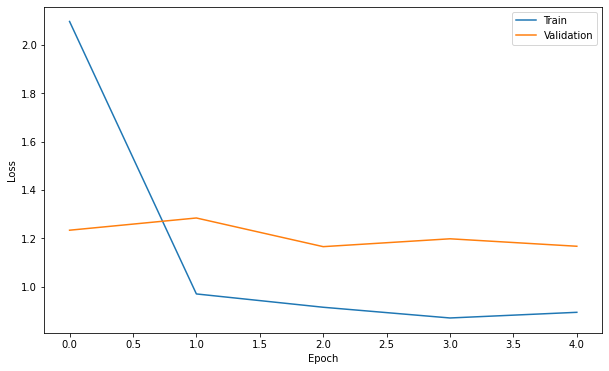

In [45]:
history = combine_histories(histories)
plot_loss(history)

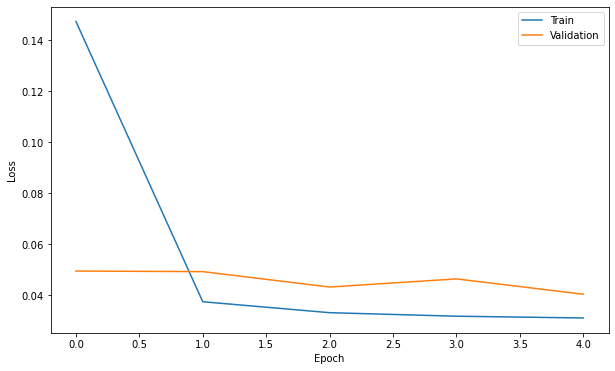

In [46]:
plot_bbox_loss(history)

## Try the model on the test set

In [47]:
def plot_prediction(row, image_dir):
    image_path = os.path.join(image_dir, row["folder"], row["image_id"] + ".jpg")
    img = image.load_img(image_path, target_size=(image_width, image_height))
    bbox_true = [row["x_min"], row["x_max"], row["y_min"], row["y_max"], row["class_name"].upper()]
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred = model.predict(x)
    bbox_pred = [*pred[1][0], labels[np.argmax(pred[0])]]
    
    plot_image(img, [bbox_true, bbox_pred])
   

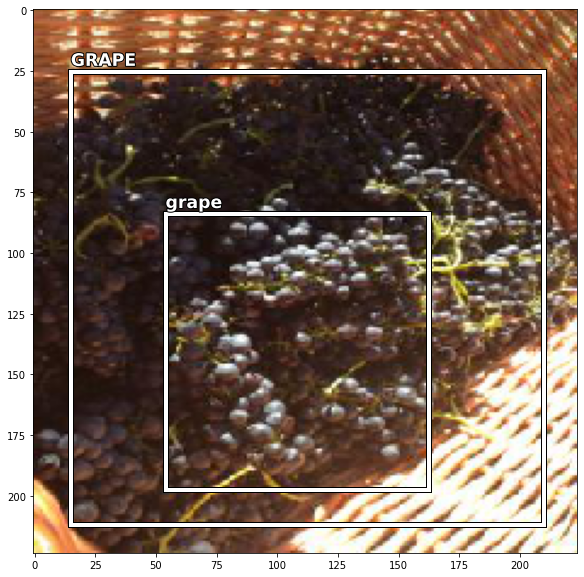

In [56]:
row_index = np.random.randint(len(test_annotations))
row = test_annotations.iloc[row_index]
plot_prediction(row, test_dir)

## Convert to mlmodel

In [57]:
import coremltools

In [58]:
coreml_model = coremltools.converters.keras.convert(model)

0 : input_3, <keras.engine.input_layer.InputLayer object at 0x7f1778374908>
1 : conv1_pad, <keras.layers.convolutional.ZeroPadding2D object at 0x7f1778374978>
2 : conv1, <keras.layers.convolutional.Conv2D object at 0x7f1778374da0>
3 : conv1_bn, <keras.layers.normalization.BatchNormalization object at 0x7f1778374a90>
4 : conv1_relu, <keras.layers.advanced_activations.ReLU object at 0x7f1778374cc0>
5 : conv_dw_1, <keras.layers.convolutional.DepthwiseConv2D object at 0x7f1778374eb8>
6 : conv_dw_1_bn, <keras.layers.normalization.BatchNormalization object at 0x7f177807c080>
7 : conv_dw_1_relu, <keras.layers.advanced_activations.ReLU object at 0x7f177807c278>
8 : conv_pw_1, <keras.layers.convolutional.Conv2D object at 0x7f177807c2b0>
9 : conv_pw_1_bn, <keras.layers.normalization.BatchNormalization object at 0x7f177807c438>
10 : conv_pw_1_relu, <keras.layers.advanced_activations.ReLU object at 0x7f177807c550>
11 : conv_pad_2, <keras.layers.convolutional.ZeroPadding2D object at 0x7f177807c588>

In [59]:
coreml_model.save('./SnackLocalization.mlmodel')